In [1]:
import pandas as pd
import os
import numpy as np

In [2]:
os.getcwd()

'/home/jupyter/finetune_LLM'

In [3]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch

In [4]:
classified_krishna_df = pd.read_csv('/home/jupyter/finetune_LLM/Data/train/processed_chunked_files_llm_finetuining_krishna.csv')
classified_sandhya_df = pd.read_csv('/home/jupyter/finetune_LLM/Data/train/processed_chunked_files_llm_finetuining_sandhya.csv')


In [5]:
classified_krishna_df

,filename,notes,classified
0,Notes_text_6768_chunk_2.txt,"WT- 64.1 KG, P-88/MIN\nWhole body pet scan 21/...","{'vitals': ['WT- 64.1 KG, P-88/MIN', 'WT- 65.8..."
1,Notes_text_6789_chunk_3.txt,"On 19.3.2022, Under Sedation I&D site opened u...","{'past_history': ['On 19.3.2022, Under Sedatio..."
2,Notes_text_6711_chunk_1.txt,MBC\nPOST MULTIPLE LINES OF TREATMENT\nON FULV...,"{'diagnosis': ['MBC'], 'past_history': ['POST ..."
3,Notes_text_6795_chunk_2.txt,"?RADIOTHERAPY INDUCED CYTOPENIA\nCBC,PS,LDH EV...",{'observation_examinations': ['?RADIOTHERAPY I...
4,Notes_text_6718_chunk_2.txt,Post 3 cycles PETCT W/B(4/3/23)-Uterus is not ...,{'investigation_report': ['Post 3 cycles PETCT...
...,...,...,...
348,Notes_text_6741_chunk_3.txt,MRI NECK 16/12/2022: 7 X 9 mm LESION IN LEFT S...,{'investigation_report': ['MRI NECK 16/12/2022...
349,Notes_text_6787_chunk_1.txt,PROXY\nRECURRENT SCC ORAL CAVITY\nKCO Ca Hard ...,"{'additional_information': ['PROXY', 'PROXY VI..."
350,Notes_text_6703_chunk_2.txt,FOLLOW UP ON 22.11.21 WITH REPORTS\nPatient is...,{'instructions_advice': ['FOLLOW UP ON 22.11.2...
351,Notes_text_6807_chunk_1.txt,MULTIPLE MYELOMA\nPOST ASCT (16/11/2017)\nBORV...,"{'diagnosis': ['MULTIPLE MYELOMA', 'IMP-', 'HE..."


In [6]:
# Concatenating the DataFrames row-wise
classified_df = pd.concat([classified_sandhya_df, classified_krishna_df], axis=0, ignore_index=True)

In [7]:
classified_df['notes_character_count'] = classified_df['notes'].str.len()

In [8]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "BioMistral/BioMistral-7B"
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_eos_token=True,
    add_bos_token=True,
)


/opt/conda/envs/python39/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
classified_df['token_count_notes'] = classified_df['notes'].apply(lambda x: len(tokenizer.encode(x)))
classified_df['token_count_classified'] = classified_df['classified'].apply(lambda x: len(tokenizer.encode(x)))

In [10]:
classified_df['num_split_notes'] = np.ceil(classified_df['token_count_notes']/1024).astype(int)

In [11]:
print(classified_df[classified_df["filename"]=="Notes_text_7202_chunk_1.txt"]["notes"])

135    CA (L) BREAST\n(L) MRM 17/06/2022\nER -/PR 10%...
Name: notes, dtype: object


In [12]:
len(classified_df)

595

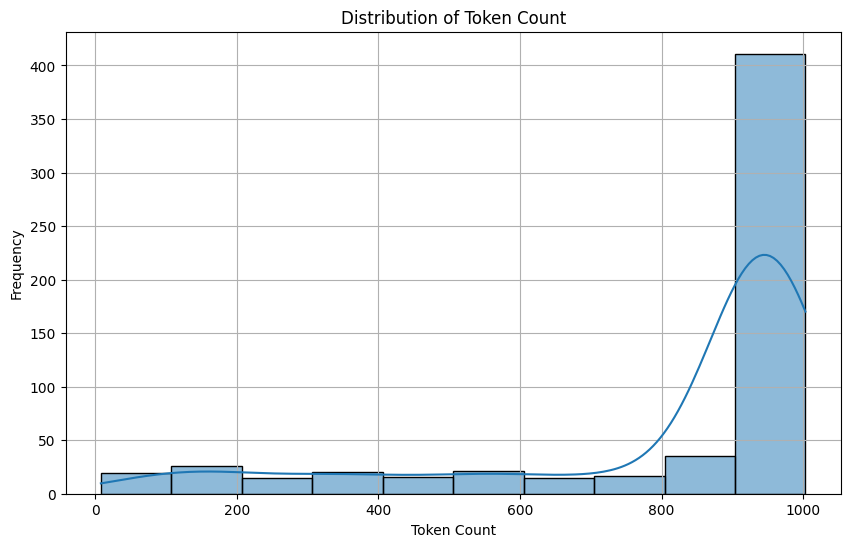

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the distribution using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(classified_df['token_count_notes'], bins=10, kde=True)
plt.title('Distribution of Token Count')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [14]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

In [15]:
from datasets import Dataset
dataset = Dataset.from_pandas(classified_df)

In [16]:
dataset

Dataset({
    features: ['filename', 'notes', 'classified', 'notes_character_count', 'token_count_notes', 'token_count_classified', 'num_split_notes'],
    num_rows: 595
})

In [17]:
dataset = dataset.train_test_split(0.1)

In [18]:
dataset

DatasetDict({
    train: Dataset({
        features: ['filename', 'notes', 'classified', 'notes_character_count', 'token_count_notes', 'token_count_classified', 'num_split_notes'],
        num_rows: 535
    })
    test: Dataset({
        features: ['filename', 'notes', 'classified', 'notes_character_count', 'token_count_notes', 'token_count_classified', 'num_split_notes'],
        num_rows: 60
    })
})

In [19]:
def tokenize(prompt):
    result = tokenizer(prompt)
    result["labels"] = result["input_ids"].copy()
    return result

In [20]:
def generate_and_tokenize_prompt(data_point):
    full_prompt =f"""Classify the notes into below categories:
                   'allergies',
                   'chief_complaints',
                   'diagnosis',
                   'family_history',
                   'history',
                   'instructions_advice',
                   'investigation_report',
                   'investigations',
                   'medicine_prescription',
                   'observations_examinations',
                   'patient_willingness_concent',
                   'personal_history',
                   'procedure_report',
                   'referral',
                   'social_history',
                   'tolerance',
                   'treatment_plan',
                   'unclassified',
                   'vitals'
                    Output the classified data into json format


### notes:
{data_point["notes"]}

### Classified:
{data_point["classified"]}
"""
    return tokenize(full_prompt)

In [21]:
train_dataset = dataset['train']
test_dataset = dataset['test']

In [22]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = test_dataset.map(generate_and_tokenize_prompt)

Map: 100%|██████████| 60/60 [00:00<00:00, 260.78 examples/s]


In [23]:
untokenized_text = tokenizer.decode(tokenized_train_dataset[1]['input_ids'])
print(untokenized_text)

<s> Classify the notes into below categories:
                   'allergies',
                   'chief_complaints',
                   'diagnosis',
                   'family_history',
                   'history',
                   'instructions_advice',
                   'investigation_report',
                   'investigations',
                   'medicine_prescription',
                   'observations_examinations',
                   'patient_willingness_concent',
                   'personal_history',
                   'procedure_report',
                   'referral',
                   'social_history',
                   'tolerance',
                   'treatment_plan',
                   'unclassified',
                   'vitals'
                    Output the classified data into json format


### notes:
k/c/o HTN
NSCLC(EGFR alk ros neative from BLK)
6 X Pem carb - Pem maintenance - aug 2019
Developed anemia
Discontinued Rx -
NGS- not possible as pt doesnt have issue

595


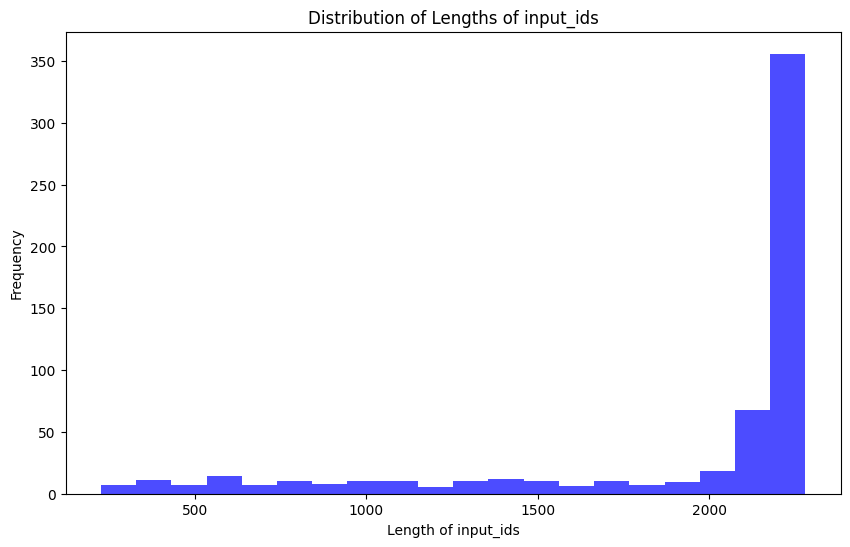

In [24]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [25]:
max_length = 2048 #1024 #20000 # This was an appropriate max length for my dataset

# redefine the tokenize function and tokenizer

tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token


def tokenize(prompt):
    result = tokenizer(
        prompt,
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [26]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = test_dataset.map(generate_and_tokenize_prompt)

Map: 100%|██████████| 60/60 [00:00<00:00, 240.35 examples/s]


In [27]:
untokenized_text = tokenizer.decode(tokenized_train_dataset[1]['input_ids'])
print(untokenized_text)

<s> Classify the notes into below categories:
                   'allergies',
                   'chief_complaints',
                   'diagnosis',
                   'family_history',
                   'history',
                   'instructions_advice',
                   'investigation_report',
                   'investigations',
                   'medicine_prescription',
                   'observations_examinations',
                   'patient_willingness_concent',
                   'personal_history',
                   'procedure_report',
                   'referral',
                   'social_history',
                   'tolerance',
                   'treatment_plan',
                   'unclassified',
                   'vitals'
                    Output the classified data into json format


### notes:
k/c/o HTN
NSCLC(EGFR alk ros neative from BLK)
6 X Pem carb - Pem maintenance - aug 2019
Developed anemia
Discontinued Rx -
NGS- not possible as pt doesnt have issue

595


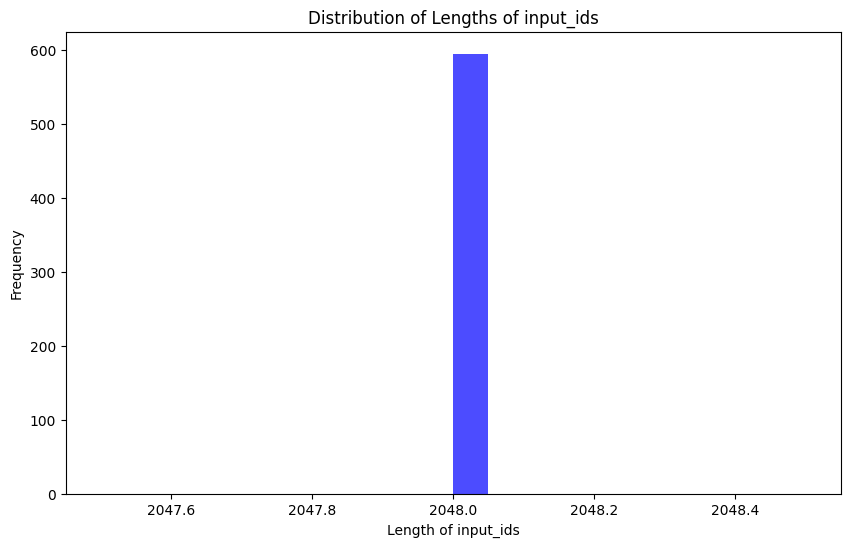

In [28]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [29]:
print("Notes: " + test_dataset[2]['notes'] + "\n")
print("Classified: " + test_dataset[2]['classified'] + "\n")

Notes: no other complaint
Height(cm) 173 Weight(kg)87.4
PR - 88/min
Chest/ PA- Normal
Oral Lesion - heeling
Skin Exam - N
HRCT- No Significant active parenchyal-or interstited
To Start Vaccination
To Start-CSA Taper
Chimerism (Day + 100) VNTK
BMA/MRD LP on 158/3/22
Cycle 3 5 Aza From 15/3/22
CSA 100mg BD
Rest CST
Vaccine as per protocol
Seen by Dr.Rohan
AML / Refractory-MRD + / MUD
+ day 89
Received 1st Cycle Azacytidine Maintenance - 18/1/22 x 3 days
Co Level - 175mg/ml
CMV - Neg. on + 84- (21/2/22)
Graft-9.7/5620/109000-N 58, L 245, M9, E2
No GVHD - Skin / Liver / Chest
Height(cm) 173 Weight(kg)84.3
Continue CSA Same Dose
FUC of AML post renal transplant
Had BK virus cystitis
Was on alfuzosin, mirago and cystopan
No urinary symptoms
Creat: 0.6 mg%
adv: continue cystopan
-Stop alfoo, mirago
post Transplant day + 68
Chimerism-Day + 30 - 100 %
Last BMA /Bx 18/1/22 - CMR
MRD - Negative
Recd Cycle 1 Maintenance Aza 18/1 to 20/1
No GVHD
Current No fresh Complaint
c./o Dry cough Reduced the

In [30]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)

`low_cpu_mem_usage` was None, now set to True since model is quantized.


In [31]:
# Apply the accelerator. You can comment this out to remove the accelerator.
model = accelerator.prepare_model(model)

In [32]:
# Re-init the tokenizer so it doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

In [33]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [34]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [35]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )

In [36]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

# Apply the accelerator. You can comment this out to remove the accelerator.
model = accelerator.prepare_model(model)

trainable params: 21260288 || all params: 3773331456 || trainable%: 0.5634354746703705


In [37]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): L

In [38]:
#!pip install wandb

In [39]:
import wandb, os
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: avijit2005in. Use `wandb login --relogin` to force relogin


True

In [40]:
wandb_project = "biomistral-finetune-identifier-chunked"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

In [41]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [ ]:
'''
from transformers import TrainingArguments

project = "snp-finetune-classifier-2024_130624_v2"
base_model_name = "biomistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

tokenizer.pad_token = tokenizer.eos_token

training_arguments = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4, # Increase, if still giving OOM error
    gradient_checkpointing=True,
    optim="paged_adamw_8bit",
    max_steps=1000,
    save_steps=500,
    logging_steps=200,
    learning_rate=2.5e-5,
    fp16=True, # Enable fp16, bf16 only if your gfx card supports it
    evaluation_strategy="steps",
    max_grad_norm=0.3,
    num_train_epochs=5.0,
    weight_decay=0.001,
    warmup_steps=50,
    lr_scheduler_type="linear",
    run_name=run_name,
    report_to='wandb',
)
'''

In [ ]:
'''
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    train_dataset=tokenized_train_dataset,#tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset, # remove you have low VRAM and getting OOM errors
    peft_config=peft_config,
    #dataset_text_field="notes",
    max_seq_length=2048, # depends on your dataset
    #tokenizer=tokenizer,
    args=training_arguments,
    formatting_func=formatting_prompts_func,
    data_collator=collator,
    #packing=False,
)
'''

In [45]:
#trainer.train()

In [42]:
os.getcwd()

'/home/jupyter/finetune_LLM'

In [43]:
import transformers
from datetime import datetime

project = "snp-finetune-classifier-2024_020724_v2"
base_model_name = "biomistral"
run_name = base_model_name + "-" + project
output_dir = "./finetuned_LLM" + run_name

tokenizer.pad_token = tokenizer.eos_token

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=5,
        per_device_train_batch_size=4,
        gradient_checkpointing=True,
        gradient_accumulation_steps=4,
        max_steps=2000,
        learning_rate=2.5e-5, # Want about 10x smaller than the Mistral learning rate
        logging_steps=100, #50,
        bf16=True,
        optim="paged_adamw_8bit",
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=500, #50,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=500, #50,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        gradient_checkpointing_kwargs={'use_reentrant': True},
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

/opt/conda/envs/python39/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


In [44]:
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

Step,Training Loss,Validation Loss
500,0.391900,0.902202
1000,0.098300,1.260307
1500,0.024800,1.550821
2000,0.008800,1.719059


/opt/conda/envs/python39/lib/python3.10/site-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/opt/conda/envs/python39/lib/python3.10/site-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/opt/conda/envs/python39/lib/python3.10/site-packages/peft/utils/save_and_load.py:180: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


TrainOutput(global_step=2000, training_loss=0.22947957682609557, metrics={'train_runtime': 33167.0523, 'train_samples_per_second': 0.965, 'train_steps_per_second': 0.06, 'total_flos': 2.799214620491907e+18, 'train_loss': 0.22947957682609557, 'epoch': 59.701492537313435})

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "BioMistral/BioMistral-7B"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
    trust_remote_code=True,
)

In [ ]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "biomistral-snp-finetune-classifier-2024/checkpoint-250")

In [ ]:
dataset

In [ ]:
eval_prompt = f"""Classify the notes into below categories:
                   'allergies',
                   'chief_complaints',
                   'diagnosis',
                   'family_history',
                   'history',
                   'instructions_advice',
                   'investigation_report',
                   'investigations',
                   'medicine_prescription',
                   'observations_examinations',
                   'patient_willingness_concent',
                   'personal_history',
                   'procedure_report',
                   'referral',
                   'social_history',
                   'tolerance',
                   'treatment_plan',
                   'unclassified',
                   'vitals'
                    Output the classified data into json format


### notes:
{dataset["test"]["notes"][1]}

### Classified:
"""
print(eval_prompt)

In [ ]:
dataset["test"]["classified"][1]

In [ ]:
%%time
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=2048)[0], skip_special_tokens=True))

In [ ]:
%%time
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=1024)[0], skip_special_tokens=True))

In [ ]:
%%time
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=512)[0], skip_special_tokens=True))

In [ ]:
import os
os.environ["WANDB_PROJECT"]="openhathi_instruct_finetuning"

from enum import Enum
from functools import partial
import pandas as pd
import torch

from transformers import AutoModelForCausalLM, LlamaTokenizer, TrainingArguments, set_seed
from datasets import load_dataset
from trl import SFTTrainer
from peft import get_peft_model, LoraConfig, TaskType

seed = 42
set_seed(seed)

In [ ]:
dataset_name = "smangrul/hinglish_self_instruct_v0"
dataset = load_dataset(dataset_name)
dataset

In [ ]:
dataset["train"][0]

In [ ]:
model_name = "sarvamai/OpenHathi-7B-Hi-v0.1-Base"
dataset_name = "smangrul/hinglish_self_instruct_v0"
tokenizer = LlamaTokenizer.from_pretrained(model_name)
template = """{% for message in messages %}\n{{'<|im_start|>' + message['role'] + '\n' + message['content'] + '<|im_end|>' + '\n'}}{% if loop.last and add_generation_prompt %}{{'<|im_start|>assistant\n' }}{% endif %}{% endfor %}"""
tokenizer.chat_template = template

def preprocess(samples):
    batch = []
    for conversation in samples["messages"]:
        batch.append(tokenizer.apply_chat_template(conversation, tokenize=False))
    return {"content": batch}

dataset = load_dataset(dataset_name)
dataset = dataset.map(
    preprocess,
    batched=True,
    remove_columns=dataset["train"].column_names
)
dataset = dataset["train"].train_test_split(0.1)
print(dataset)
print(dataset["train"][0])